<h3 align="Center">
    <img alt="Logo" title="#logo" width="250px" src="https://www.nerdwallet.com/cdn-cgi/image/quality=85/cdn/loans/edu/stride.png">
    <br>
</h3>

# <center> **Early warning model for credit default**
## <center> **Methodologic report**
### <center> **Funding Credit team**
### <center> Analysts:
### <center> *Kevin M. Figueroa*
### <center> *September 19th 2022*

_________________________________________________________________________________________________________________________________________________

# <center> Methodologic report

### 0. Importing libraries and data, and general setup

#### Importing libraries and setting up the environment

To see functions created for this project see [Stride functions file]('stride_functions.py')

In [1]:
# Importing libraries Libraries
# User defined functions
from stride_functions import *                                                   # See file stride_functions.py
# Standard libraries
import numpy as np
import pandas as pd
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
#from pandas import MultiIndex, Int16Dtype
# Plotting libraries
import matplotlib.pyplot as plt 
import seaborn as sns
# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ks_2samp
from pycaret.classification import *
# Date and time libraries
import datetime as dt
import time as tm
# Keep graphs in line
%matplotlib inline
# Show all columns in pandas
pd.set_option('display.max_columns', 500)
# Graphing style
plt.style.use('seaborn-colorblind')

#### Importing data from csv files

In [2]:
# Importing training data provided
df_train = pd.read_csv('data/train.csv')
# Importing testing data
df_test = pd.read_csv('data/test.csv')

#### Setting up column names

In [3]:
# Converting all column names into lowercase and removing any spaces
df_train.columns = [x.strip().lower() for x in df_train.columns]
# Converting all column names into lowercase and removing any spaces
df_test.columns = [x.strip().lower() for x in df_test.columns]

### 1. Exploratory data analysis

#### Understanding data shapes
We are provided with the following two sets of data containing information about past costumers, including their payment behavior.

- A training dataset, containing 16,671 observations with 11 features and 1 target variable to predict.
- A testing dataset with brand new data, including 4,168 cases with the same 11 features but no target.

Both datasets contain the same features.

**shapes_exploration function** 

Explores the shapes and columns of training and testing dataset

In [4]:
# Create a list to keep track of original quantitative columns
original_cols = df_train.columns.drop(['id', 'date_of_birth']).to_list()      # Drop id and date of birth                 
original_cols.append('age')                                                   # Add age       

shapes_exploration(df_train, df_test)

Training dataset
- Observations: 16671
- Attributes: 11
- Target: 1
Testing dataset
- Observations: 4168
- Attributes: 11
Same columns: No issues


**summary_stats function**

The summary_stats function creates a Summary table of the variables contained in the dataset

#### Understanding features

Tables 1 and 2 contain a general summary of the variables we were provided, including the count, mean, standard deviation, and location measures, as well as the data types. In addition, training data includes a column that tracks any missing values in the data. 

The data doesn't contain an official description of the variables. It is our task to infer what the variables represent. Based on the exploration made in this section, this is the initial description of the data:  

- *id*: A unique identifier of each of the clients.

    No repeated ids, implying that each client has only been granted one loan. 

- *date_of_birth*: Birth date of the client.

- *number_dependants*: Number of people that depend directly on the client's income.

- *credit_utilization*: % of the credit limit that the individual has used. 

- *debt_to_income_ratio*: Ratio of debt to income.

- *monthly_income*: Total income that the client receives every month.

- *number_open_credit_lines*: Number of open credit lines that the client has. 

- *number_open_loans*: Numer of loans that the client has received that haven't been paid off

- *number_90_days_past_due*: Number of accounts in which the client has 90+ days past- due

- *number_charged_off*: Number of debt accounts in which the client has been charged off

- *score1 and score2*: The data contains two scores grades and it is not clear what is the difference between them. There are two possibilities:

    - Scores are collected from different credit reporting institutions: It is difficult to test this hypothesis since the three main credit institutions use similar ranges. 

    Equifax -> 250-850;  Experian -> 300-850;  Transunion -> 300-850

    - Scores are collected at different moments in time: It could be the case that one of the scores was taken before the loan was disbursed and the other at some specific point during the duration of the loan. In this case, the difference would represent the evolution of the credit performance of the client. If this were the case, it will be assumed that *score1* was collected before *score2*. 

- *target*: Binary variable that shows if an individual defaulted (1 if defaulted and 0 if not)

From this original set of variables there are a few others that we can safely infer that might be useful for the analysis: 

- *age*: Age of the individual at the end of the loan or time of default.

- *total_debt* (*debt_to_income_ratio* * *monthly_income*): Total debt accounts of the individual.

- *number_accounts* (*number_open_credit_lines* + *number_open_loans*): Total number of debt accounts of the indivudual.

- *avg_loan* (*total_debt* / *number_accounts*): Averge laon amount non-paid by the individual. 
 
    Knowing the original amount of the accounts would be better to obtain variables such as monthly payments

- *90_days_pct* (*number_90_days_past_due* / *number_accounts*): Percentage of accounts with 90 days past-due.

- *charged_off_pct* (*number_charged_off* / *number_accounts*): Percentage of accounts charged off.

- *avg_score* (*score1* + *score2*) / 2: Average score. 

- *score_change* (*score2* - *score1*): Change of the credit score.

**gen_variables function**

gen_ variables computes all the new variables mentioned previously. 

In [5]:
# Create new df with original and new variables for training set
df_train_new = gen_variables(df_train)
# Create new df with original and new variables for testing set
df_test_new = gen_variables(df_test)

# Applying function to traiinng data
title = 'Table 1. Summary of variables training set'
summary_stats(df_train_new, title)                                      # Show only original columns 

                                       Table 1. Summary of variables training set                                       


,count,mean,std,min,25%,50%,75%,max,Missing vals,Variable type
number_dependants,16671.0,0.49,0.72,-1.00,0.00,0.00,1.00,6.00,False,int64
credit_utilization,16671.0,0.05,0.05,0.00,0.01,0.03,0.07,0.54,False,float64
debt_to_income_ratio,16671.0,0.33,0.12,0.03,0.25,0.33,0.41,0.80,False,float64
monthly_income,16671.0,2289.90,319.47,2000.00,2100.00,2200.00,2400.00,5000.00,False,int64
number_open_credit_lines,16671.0,5.00,2.25,0.00,3.00,5.00,6.00,15.00,False,int64
number_open_loans,16671.0,2.03,1.43,0.00,1.00,2.00,3.00,9.00,False,int64
number_90_days_past_due,16671.0,0.10,0.32,0.00,0.00,0.00,0.00,3.00,False,int64
number_charged_off,16671.0,0.10,0.32,0.00,0.00,0.00,0.00,3.00,False,int64
score1,16671.0,669.90,98.01,500.00,585.00,669.00,756.00,839.00,False,int64
score2,16671.0,669.49,98.61,500.00,583.00,670.00,754.00,839.00,False,int64


In [6]:
# Sunnarizing new testing data
title = 'Table 2. Summary of variables testing set'
# summary_stats(df_test_new, title)

#### Understanding target
Because we are trying to predict a binary variable, it is important to know what is the proportion of defaulted loans. 
Figure 1 shows the percentage of defaulted vs Non-defaulted loans. We have a quite unbalanced sample, with Non-default loans representing around 90% of the cases, and Default loans representing only 10% of the cases. 

Trying to preserve these proportions will be important when splitting the data to test the model's performance.

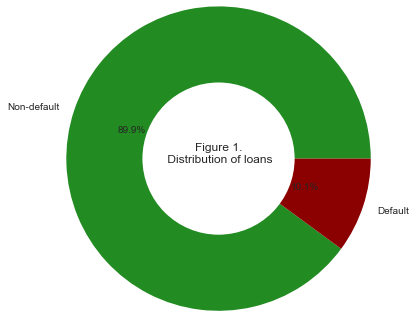

In [7]:
# Create pie chart of target variable distribution
type_frequencies = df_train['target'].value_counts(normalize='true')    # Count values

# Plot pie chart
fig, ax = plt.subplots()
ax.pie(type_frequencies, labels=['Non-default', 'Default'], 
        autopct='%1.1f%%', radius=2, colors=['forestgreen', 'darkred'])
fig.set_size_inches(3.5,3.5)
circle = plt.Circle(xy=(0,0), radius=1, facecolor='White')
plt.gca().add_artist(circle)
ax.set_title('Figure 1.\n Distribution of loans', y=0.45)

plt.savefig('figures/target_pie.png')

#### Scales and extreme values
Figure 2 shows the Boxplots for all original variables. It is clear that we are dealing with different scales (e.g. number_dependants ranges from 0 to 6 while monthly_income ranges from 2,000 to 5,000). 

To correct this issue, we must transform the data with some standardization, so the analysis focus on the relationship between the variables and not on the scales. 
Standardized data is essential for accurate data analysis; it’s easier to draw clear conclusions about your current data when you have other data to measure it against using the same units. 

Standardization will also allow us to reduce any potential skew that outliers might have over our sample. From Figure 2, it is easy to see that all the data, except for scores 1 and 2, include some outliers. In particular, 90 days past due and charged-off accounts present some extreme observations. This situation will be something to keep in mind when evaluating the model's performance.

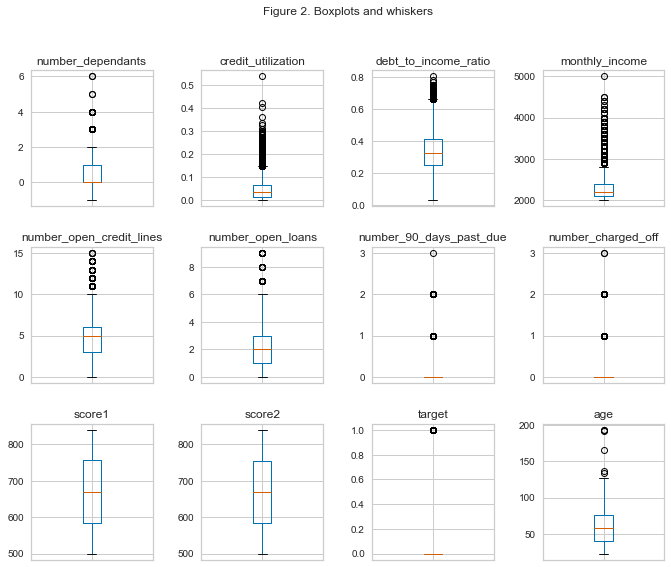

In [8]:
# Generate boxplots for each variable
fig, ax = plt.subplots(3,4)                                                 # Create a 3x4 grid of subplots
fig.set_size_inches((11,8))
fig.suptitle('Figure 2. Boxplots and whiskers', y=1.01)
plt.subplots_adjust(left=0.1,                                               # Adjust the space between the subplots
                    bottom=0.05, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.3)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 0
for row in range(3):                                                       
    for col in range(4):                                                    
        current_col = original_cols[col_index]                              
        ax[row][col].set_title(current_col)
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=True, right=False, labelleft=True, labelbottom=False)
        df_train.boxplot(column=[current_col], ax=ax[row][col])
        col_index += 1
plt.savefig('figures/boxplots.png')

#### Understanding distributions by target case

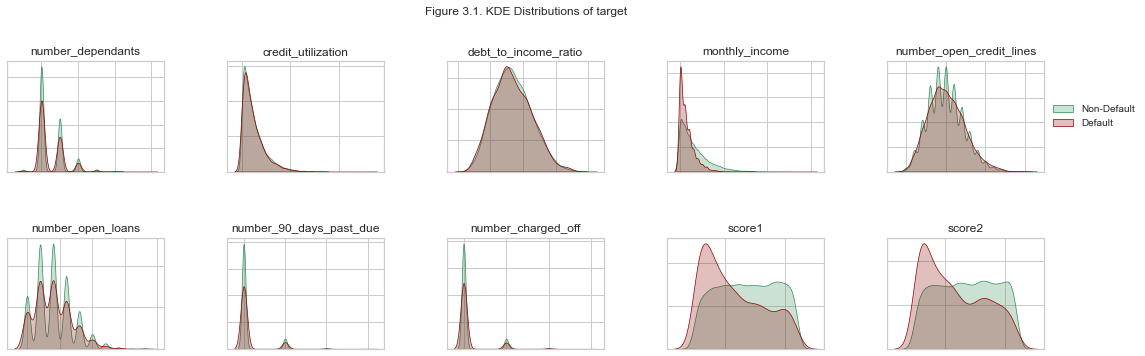

In [9]:
cols = ['number_dependants',
 'credit_utilization',
 'debt_to_income_ratio', 'target']
#sns.pairplot(data=df_train[cols], hue='target', diag_kind='kde', height=4, palette=['forestgreen', 'darkred'])

# Plot of the distribution of variables between training and testing
fig, ax = plt.subplots(2,5)                     # Create a 5x2 grid of subplots
fig.set_size_inches((18,5))
fig.suptitle('Figure 3.1. KDE Distributions of target', y=1.05)
plt.subplots_adjust(left=0.1,                   # Adjust the space between the subplots
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 2
for row in range(2):                                                        # Rows loop
    for col in range(5):                                                    # Columns loop
        current_col = df_train.columns[col_index]                           # Curent column
        ax[row][col].set_title(current_col)
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=False, right=False, labelleft=False, labelbottom=False)
       
        sns.kdeplot(df_train[df_train['target'] == 0][current_col], color='seagreen', 
                    fill=True, ax=ax[row][col], lw=0.7)

        sns.kdeplot(df_train[df_train['target'] == 1][current_col], color='darkred', 
                    fill=True, ax=ax[row][col], lw=0.7)

        col_index += 1
    
ax[0][4].legend(['Non-Default', 'Default'], loc='center left', bbox_to_anchor=(1, 0.5))

# Save image
plt.savefig('figures/kde_default_nondefault.png')

#### Exploring correlations between variables and selecting initial variables

Figure 3 shows correlation and absolute correlation matrices. In terms of the signs shown, a positive correlation means that the higher the value of the feature the higher the probability of default, and a negative correlation means the higher the feature the probability of default decreases. 

Unfortunately, none of the variables presents an significant correlation with the target variable. This means that a model will not be able to rely on a single feature to guide the decision, but rather on a more complex process including many features. It will be our task to decide which variables to keep and which to drop

**Highest correlations**

- Monthly income (-0.16): with the expected negative sign, as more income should imply fewer chances of defaulting
- Score1 (-0.14), Score2 (-0.13), avg_score(-0.18): with the expected negative sign, as better payers should have higher scores. 

**Feature selection**

- An interesting finding is that the evolution of the score score_change(+0.10) presents a significantly lower correlation than avg_score, however, the sign makes no intuitive sense, as people improving their credit score should not represent higher risks than people decreasing their scores.  From now on, we will assume that the difference between score1 and score2 is the source of the score, and **score_change will be dropped**. 

- Since avg_score (-0.18) will be capturing the effect of credit score, individual features **score1 and score2 will be dropped** because of the multicollinearity they present. 

- As total_debt (-0.06) was a variable derived from debt_to_income_ratio (-0.16), it presents a multicollinearity issue. Since its' correlation is lower than that of the ratio, **total_debt will be dropped**.

- number_open_credit_lines (+0.01) and number_open_loans (-0.01) seem to be having different impact on default probability. It may be the case that good repayers have no issue with taking a loan, and bad repayers prefer flexible credit lines. In any case, the variable number_accounts was created to represent the impact of both variables in one. However, since the impact is going in different directions **number_accounts will be dropped**.  

- number_90_days_past_due (+.01) and 90_days_pct (+0.02) are meant to represent similar features. Having the feature in terms relative to their total debt and a slightly higher correlation, 90_days_pct will be kept, and **number_90_days_past_due will be dropped**

- For a similar reason as above, **number_charged_off (0.0) will be dropped** and charged_off_pct (0.0) will be kepts.

**corr_matrix function**

Plots the correlation matrix and absolute correlation matrix.

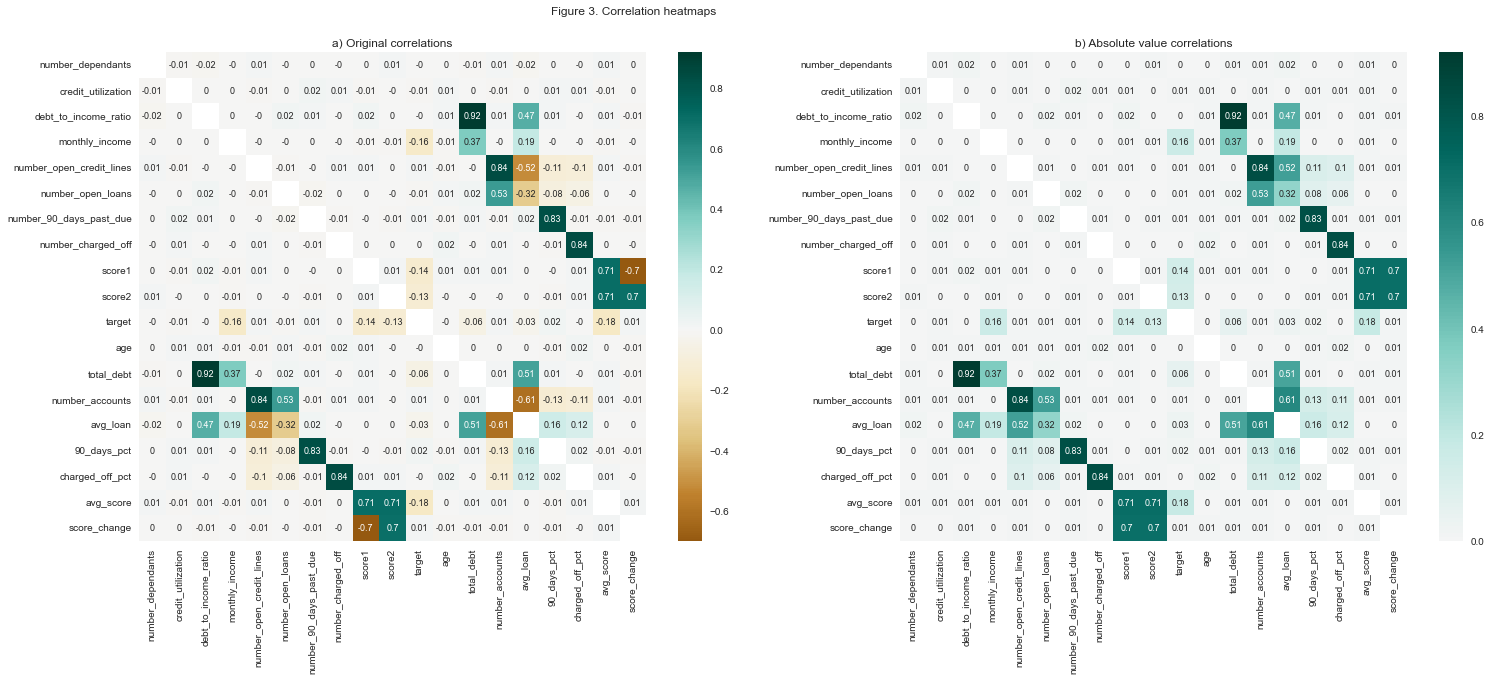

<Figure size 432x288 with 0 Axes>

In [10]:
corr_matrix(df_train_new, file_name= 'corr_heatmaps.png')

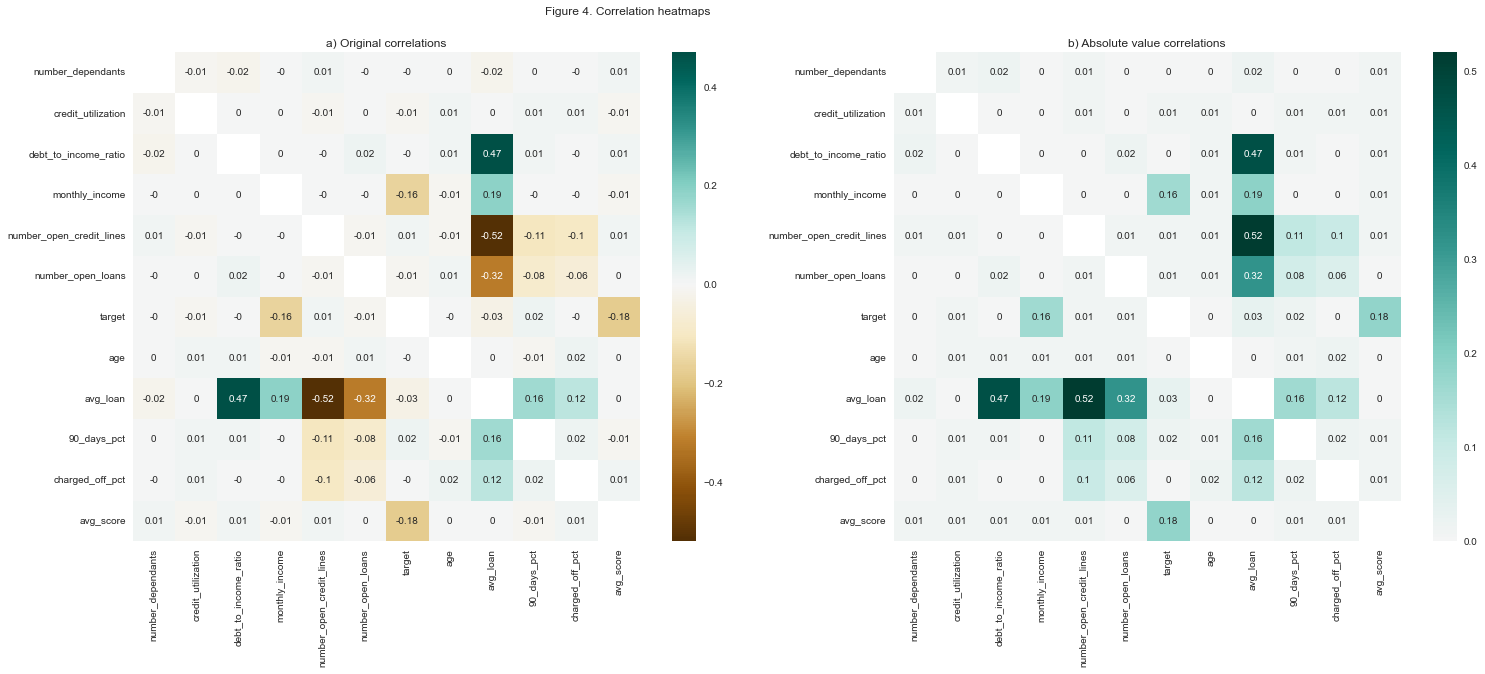

<Figure size 432x288 with 0 Axes>

In [11]:
# Dropping columns:
keepers = list(df_train_new.columns)
keepers.remove('score_change')                # Failed hypothesis
keepers.remove('score1')                      # Multicol
keepers.remove('score2')                      # Multicol
keepers.remove('total_debt')                  # Multicol
keepers.remove('number_accounts')             # Failed hypothesis
keepers.remove('number_90_days_past_due')     # Multicol
keepers.remove('number_charged_off')          # Multicol

corr_matrix(df_train_new[keepers], file_name='corr_matrix_keepers.png', annot_size = 10, fig_num=4)

#### Evaluating if both samples were drawn from the same population

Before doing any further analysis, it is important to verify that the distributions of both the training and the testing samples were drawn from populations with the same distributions. If this wasn't the case, it would be like trying to predict the behavior of people in the US by studying data of people from the UK, and therefore, our analysis would lack validity and consistency.
To perform this evaluation, the Kolmogorov-Smirnov for two samples test (KS2) was used. This test evaluates the hypothesis that both samples were drawn from the same distribution. The graph below shows the Kernel Density Estimations (KDE) for every variable of each sample. Only by scanning the graphs, it is very clear that both samples show similar distributions for all the variables involved. We can also verify that by taking a look at the KS2 p-values. Using a 95% confidence level, as long as the p-value is higher than 0.05, we cannot reject the hypothesis that both samples were drawn from the same distribution. In this case, all the p-values obtained are greater than 0.05. Hence, we can confidently move forward knowing that any result obtained will apply to our testing set. 

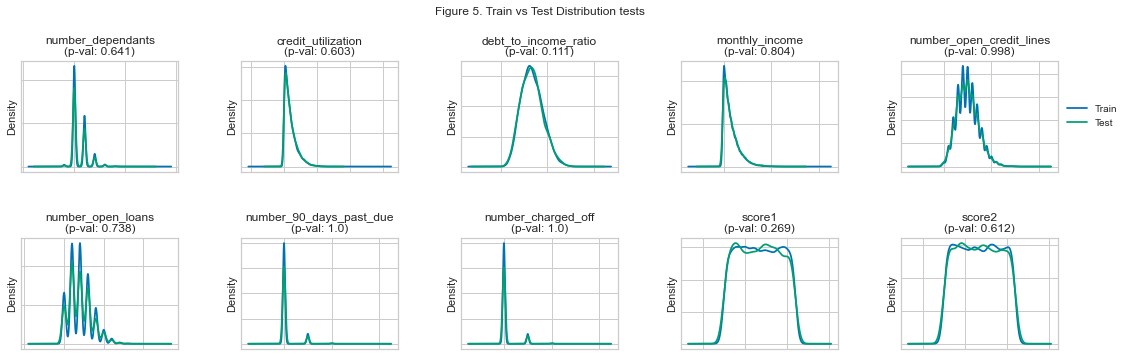

In [12]:
# Plot of the distribution of variables between training and testing
fig, ax = plt.subplots(2,5)                     # Create a 5x2 grid of subplots
fig.set_size_inches((18,5))
fig.suptitle('Figure 5. Train vs Test Distribution tests', y=1.05)
plt.subplots_adjust(left=0.1,                   # Adjust the space between the subplots
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)
# Iterate over the plots and the quantitative variables
# to create Kernel Density Estimations (KDE) plots
col_index = 2
for row in range(2):                                                        # Rows loop
    for col in range(5):                                                    # Columns loop
        current_col = df_train.columns[col_index]                           # Curent column
        p_val = ks_2samp(df_train[current_col], df_test[current_col])[1]    # Kolmogorov-Smirnov test for goodness of fit (p-val)
        ax[row][col].set_title(current_col + '\n' + 
                             '(p-val: {})'.format(round(p_val, 3)))
        ax[row][col].tick_params(top=False, bottom=False,                   # Remove ticks
        left=False, right=False, labelleft=False, labelbottom=False)
        df_train[current_col].plot.kde(ax=ax[row][col])
        df_test[current_col].plot.kde(ax=ax[row][col])
        col_index += 1
    
ax[0][4].legend(['Train', 'Test'], loc='center left', bbox_to_anchor=(1, 0.5))

# Save image
plt.savefig('figures/train_vs_test_dist.png')

#### Initial findings of Exploratory analysis

**Credit scores**

It is difficult to conclude what is the difference between the two score records. We account for two possibilities:

- Hypothesis 1: Scores come from different credit rating institutions: We generated a variable that computes the average score.

- Hypothesis 2: Scores were collected at different times: We generated a variable that computes the difference in scores. 

The correlation analysis allowed us to see the significant difference in the correlation that these two hypotheses had with the target. The data showed that Hypothesis 2 was not strong enough. Therefore, we will assume that Hypothesis 1 is correct.


**Missing Values**

As shown in Tables 1 and 2, none of the **original** columns contain any missing information. However, column number_dependants contains minimum values of (-1), which, given the nature of the variable, is not possible. Some data sources tend to use (-1) to reflect missing values after processing the data to avoid showing NaN values. 

The training dataset contains 178 missing values, while the testing data contains 31. Therefore, we will assume that such observations represent missing information, and will be treated as such. To deal with this situation, the missing values will be replaced with the mode of dependants.

**Age discontinuity**

There seems to be a typo mistake in some dates of birth. From the Tables above, we can see that the maximum age is 193. As a reference, the oldest known person alive in 2022  is 118 years (Source: Guinness Records). Hence any observation above that threshold has to be a mistake.

Diving deeper into the training data, we can see there is a discontinuity point around 94 years old, which then jumps to 126 and up to 193. This jump can be seen more clearer in the figure below. The most likely explanation for this is that there is a typo in the years of birth (e.g 1896 instead of 1996). The training data contains 7 cases with this typo, while the testing set does not contain any. These observations will be corrected by subtracting 100 years from the age. 

**How to properly take advantage of this data? Early Warning for collections**

Another issue that arises with the age analysis has to do with the nature of the loans. When evaluating a new application the age of the client before the loan will be the one available. However, this data doesn't seem representative of the age before the debt. One would expect that the ages for student loans would lie between 20 and 40 yrs. The age variable provided to us has only 25% of the observations below 41 years, suggesting that it represents the age at some point in the life of the loan. 

Because the testing data we are trying to predict contains the same inconsistency, this is a variable that most likely will be useful for the scope of this project, but will probably be meaningless when trying to predict new loan performances. A useful piece of information that would solve this situation is to have the date when the loans were disbursed. Knowing the initial date, we can infer the age that the client had at the time of the disbursement. 

Consequently, a similar concern arises with the rest of the variables. This issue would make any model created with this data meaningless for underwriting strategies. That doesn't mean that nothing can be done with all this information. It will be useful to create a tool to track loans and predict if an already existing loan is likely to default any time soon. Some kind of early warning alert for the collection department, so that the collection team can direct the efforts to those loans that will likely default soon and potentially recover a higher amount. 


**Other types of debt**

While there are observations that have no open accounts of any of the two kinds, not a single case has a total debt of 0, implying that there are other types of debt in addition to loans and credit lines. This debt can represent commercial debts such as phone or cable bills, or fiscal debt to the IRS in taxes not paid. Training and testing data contain 9 and 6 of such cases respectively. 

**Rescaling needed**

The dataset contains different ranges among the variables, representing potential noise for modeling purposes. A standardization or normalization process will be needed to rescale the variable's ranges. Because most of our features do not follow a normal distribution, standardization is the safest way to proceed. For this case, a MinMax scaler will be applied after splitting the data to prevent data leakage. 

**Unbalanced target distribution**

We have a highly unbalanced distribution of observations of the target variable. Non-default loans represent almost 90% of the total, while Default loans represent only 10%. This fact can create skews when training a model if the samples are not similarly balanced when splitting the data. Some kind of crossed-validation will help prevent these issues. 

This information also provides a solid initial benchmark in terms of accuracy for our model. The easiest model to build would be to predict only non-defaulters, and just like that we would score a 90% accuracy, but a recall and precision of 0%. 

**Weak correlations and multicolinearity**

The dataset doesn't contain features that relate in a significant way to our target variable. As a result, any model would have to rely deeper on a combination of decision rules, rather than on specific features. 

Some of the variables that were created represent multicolinearity issues, and some data does not make intuitive sense in terms of the direction of the relation. A set of variables with any of these conflicts was dropped from the dataset.

**Training sample and testing sample were drawn from the same population**

Kolmogorov-Smirnov for two sample tests (KS2) shows that every variable follows the same distribution for each of the samples. Knowing this fact, allows us to assume that any conclusion or model obtained from the training data will apply to the testing data. 

**Additional variables and data sources to consider**

After this extensive analysis and based on my expertise as a credit analyst, these are some useful variables that could be added to the data that might have stronger correlations with the target variable. There is one main feature that becomes relevant for Stride's scope, and that is to project future cashflows of students after graduation. Most of the variables listed below have that goal in mind.

(Potential sources for these variables are shown inside parenthesis)

- **repeated_client** (internal data): It is safe to assume that if a client has already performed well in a loan with Stride the probability of a default in additional credits will be small. In my experience, only 7% of repeat clients defaulted on their subsequent loans. Since the description of the data mentioned that each observation represented a client, it was assumed that no individual had repeated loans, but it would be something worth looking into.

- Loan terms (internal data): Knowing the general characteristics of the loan that was defaulted is crucial when explaining why someone defaulted. It might be the case that the amount was higher than he was able to pay the interest rate could have been too expensive, if the term was too long, you face issues such as potential deaths or accidents. Adding variables such as **loan_amount**, **interest_rate** and **term** would allow to control for this situations. 

- **initial_date** (internal_data): As mentioned before, this dataset is ambiguous about when was all the information collected. Adding an initial date of the loan would allow us to derive information such as the age of the client when hiring, and control for environmental effects such as a recession in the economy, or in his working sector. 

- Information about the program to attend (require acceptance letter in application): Following the reasoning above, knowing more information about the program that the client intends to attend would allow predicting with more precision information such as **grad_income** (Income after graduation), **sector** where he could work and **school** where the program will be taken. 

- **gpa_level** (require transcripts of previous academic levels and follow-up after graduation): Track the academic performance of the client would help to know his potential future job opportunities. 

- **gym_membership** (ask during application): A phenomenon that I studied in my previous position was the relationship between payment behavior and subscriptions, especially for people without a credit record. The hypothesis was that subscriptions represent a similar situation as that of a loan in terms of requiring a periodic payment. While most subscriptions such as streaming services and cellphone plans were not significant, having a gym membership was significant. The reasoning behind this fact is behavioral. In simple terms, having a gym membership can be used as an instrumental variable of "level of responsibility", as not only does it require to be periodically paid, but also implies that (in most cases) the individual attends the gym on a regular base, which impacts many branches such as health condition (less likely that they could die or get sick) and self-esteem. 

- **country** (legal id of the client): Knowing what is the country of the students, to where they most likely return, can also help project future cash flows.

Missing values
- Total missing values training : 178
- Total missing values testing : 31
No credit history
- Total clients without history training : 9
- Total clients without history testing : 6
Age
- Total clients over 95 years train: 7
- Total clients over 95 years train: 7


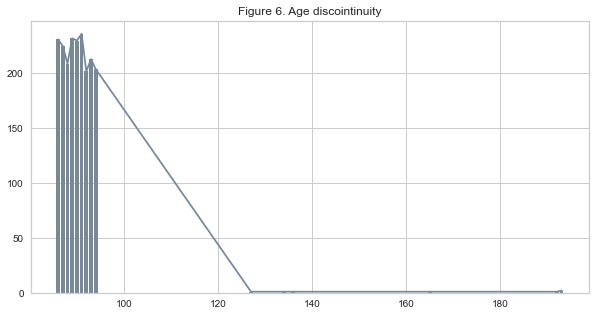

<Figure size 432x288 with 0 Axes>

In [13]:
issues_recap(df_train_new, df_test_new)

### 2. Data cleaning
Based on the exploratory analysis, there are a couple of corrections needed:

- Deal with the missing values (-1) of the number of dependants column

- Correct wrong ages by reducing 100 years to the ages of the clients that present this error. 

- Apply a standardization method to the variables. 

**Reducing dataframe to columns that were not dropped**

In [14]:
# Reducing training dataframe
df_train_new = df_train_new[keepers]                    # Keepers refer to the list of variables that were not dropped
# Reducing testing dataframe
keepers.remove('target')                                # testing data doesn't contain a target column
df_test_new = df_test_new[keepers]
keepers.append('target')

#### Filling misssing values and fixing age typo

**fill_missing function**

Number of dependants is the only column that contains missing values represented by a (-1). Instead of simply dropping the observations, missing values will be filled with the mode of the number of dependants of the sample. The reasoning behind using the mode instead of the mean is to avoid extreme values to skew the model. 

**fix_age function**

Date of birth was the only variable with a typo, and it was impacting the age variable. To fix this issue, we are going to subtract 100 years to observations over 118 years old. 

In [15]:
# Filling missing values and correcting age training
df_train_new = fill_missing(df_train_new)
df_train_new = fix_age(df_train_new)
# Filling missing values and correcting age training
df_test_new = fill_missing(df_test_new)
df_test_new = fix_age(df_test_new)

# Displaying new summary
summary_stats(df_train_new, title='Table 3: Summary after corrections')

                                           Table 3: Summary after corrections                                           


,count,mean,std,min,25%,50%,75%,max,Missing vals,Variable type
number_dependants,16671.0,0.50,0.71,0.00,0.00,0.00,1.00,6.00,False,int64
credit_utilization,16671.0,0.05,0.05,0.00,0.01,0.03,0.07,0.54,False,float64
debt_to_income_ratio,16671.0,0.33,0.12,0.03,0.25,0.33,0.41,0.80,False,float64
monthly_income,16671.0,2289.90,319.47,2000.00,2100.00,2200.00,2400.00,5000.00,False,int64
number_open_credit_lines,16671.0,5.00,2.25,0.00,3.00,5.00,6.00,15.00,False,int64
number_open_loans,16671.0,2.03,1.43,0.00,1.00,2.00,3.00,9.00,False,int64
target,16671.0,0.10,0.30,0.00,0.00,0.00,0.00,1.00,False,int64
age,16671.0,58.41,20.47,23.00,41.00,58.00,76.00,94.00,False,int64
avg_loan,16671.0,131.26,97.10,0.00,74.74,107.93,157.12,1895.99,False,float64
90_days_pct,16671.0,0.02,0.07,0.00,0.00,0.00,0.00,2.00,False,float64


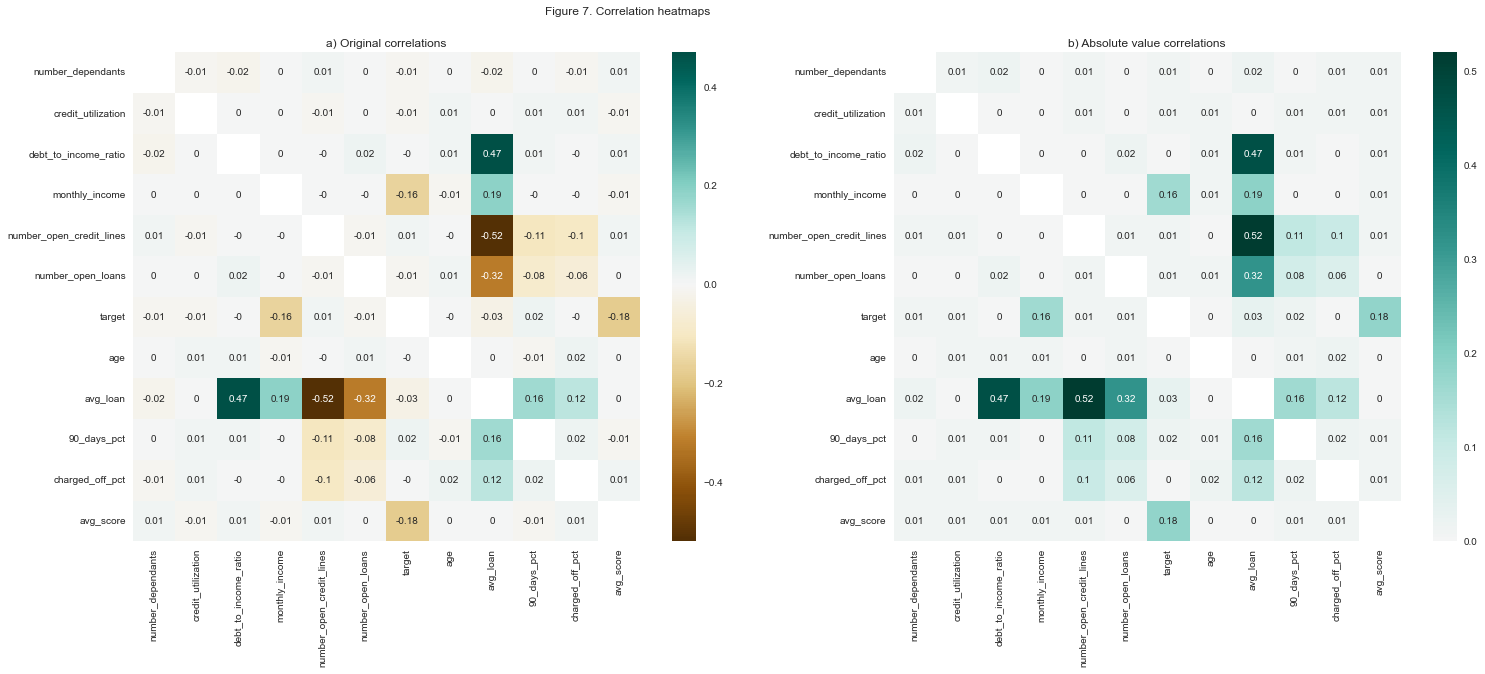

<Figure size 432x288 with 0 Axes>

In [16]:
corr_matrix(df_train_new, annot_size=10, fig_num=7, file_name='corr_matrix_missing_fixed.png')

#### standarization function

The following function allows us to easily standardize a given column from a data frame. For now, it won't be used, as it could cause data leakage problems if the data is transformed before we split our training and testing set, but it will come useful in the next sections.

### 3. Model creation

#### Contextualizing concepts

**Groups**

Because the group we are trying to predict is default loans we have the following groups:

- Positives observation: Defaulted loans (Contain the target we want to predict)

- Negatives observations: Non-defaulted loans (Doesn't contain the target we want to predict)

**Possible outcomes** 

See Table 4 below.

**Evaluation metrics**

- Accuracy: How is the model predicting both defaulters and non-defaulters?

- Precision: What percentage of the default cases predicted were actual defaulters?

- Recall: What percentage of the actual defaulters was the model able to predict?

**Best evaluation metric**

From a business perspective, there is a single trade-off to keep in mind when developing risk models to evaluate loan applications Underwriting amount vs. Delinquent portfolio. Models that can have high accuracy to predict default loans usually will approve fewer loans, leading to lower portfolio levels. On the other hand, models that approve a large number of applications will likely let more potential defaulters into the portfolio, leading to a higher amount of delinquent portfolio levels. There is no right or wrong answer to what kind of model to prefer, it will all depend on the risk appetite and the stage of the financial institution. For new fintech startups that are just starting to grow, usually, conservative models are preferred, as many Institutional Lenders (IL) give a high weight to delinquent portfolio levels when investing capital in a firm. Riskier models are more suitable for companies that have some years in their markets, with a solid portfolio level, that is trying to increase their market share. 

Because this won't be a model to evaluate applications before granting the loans, but rather a tool that can be used to predict potential defaults in existing loans, the decision of which metric to use is not as complex. For this type of tool, the most important goal is to accurately predict as many potential defaulters as possible, as the loans have already been granted, which is what the **Recall** metric provides. However, we also want to take into consideration the rest of the metrics, as the tradeoff, in this case, implies the effort of the collection department. If we predicted all cases as potential defaulters, there would be no optimal allocation of energy from the team, and the model will be useless.  

In [17]:
# Illustrative table of cases
possible_outcomes()

           Table 4. Possible outcomes           


,Predicted Non-default,Predicted Default
Non-default,True negative,False positive
Default,False negative,True positive


#### Splitting and standarizing training data into training and testing sets

To test the accuracy of the models we built, we are going to allocate a portion of the training data (which contains the correct predictions) to train our models, and the rest of the data will be used to evaluate the performance metrics in "unseen" data. 

The proportion will be: 

- 80% of the observations (13,336) will be used for training purposes.

- 20% (3,335) of the observations for testing purposes. 

Because of the imbalanced situation that we face, we are going to keep the same proportion of positive observations (defaults) in both sets to avoid potential skews.

After splitting, the standardize function described before will be applied.

In [18]:
df_train_new = df_train_new.reset_index(drop=True)
# Create matrix of features X
X = df_train_new.drop(columns='target')                                          # Remove target (y)
# Extract target as y vector 
y = df_train_new['target']

# Split the data                                                       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,        # Stratify to keep proportions of y      
                                                    stratify=y, random_state=0) # Random state to replicate results

# Standarize X sets
X_train = standarize(X_train)
y_train = pd.DataFrame(y_train).reset_index(drop=True)                         
X_test = standarize(X_test)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

summary_stats(X_train, title='Table 4. Summary of standarized testing set')

                                      Table 4. Summary of standarized testing set                                       


,count,mean,std,min,25%,50%,75%,max,Missing vals,Variable type
number_dependants,13336.0,0.08,0.12,0.0,0.00,0.00,0.17,1.0,False,float64
credit_utilization,13336.0,0.09,0.08,0.0,0.03,0.06,0.13,1.0,False,float64
debt_to_income_ratio,13336.0,0.39,0.15,0.0,0.28,0.38,0.50,1.0,False,float64
monthly_income,13336.0,0.10,0.11,0.0,0.03,0.07,0.13,1.0,False,float64
number_open_credit_lines,13336.0,0.33,0.15,0.0,0.20,0.33,0.40,1.0,False,float64
number_open_loans,13336.0,0.23,0.16,0.0,0.11,0.22,0.33,1.0,False,float64
age,13336.0,0.50,0.29,0.0,0.25,0.49,0.75,1.0,False,float64
avg_loan,13336.0,0.07,0.05,0.0,0.04,0.06,0.08,1.0,False,float64
90_days_pct,13336.0,0.01,0.03,0.0,0.00,0.00,0.00,1.0,False,float64
charged_off_pct,13336.0,0.02,0.06,0.0,0.00,0.00,0.00,1.0,False,float64


**plot_confusion_matrix function**

Function that plots confusion matrix with performance metrics

#### Null model
This is the simplest model we can build. That is, we are going to simply predict the most common case. Recall that we had an unbalance target variable in which around 90% of the data were non-defaulters and 10% were defaulters. It will be a simple example to understand how to evaluate a model. 

- In this case, the model has an accuracy of 89.91%, because it is only accurately predicting non-defaulters.

- Recall and precision are 0% since it does not predict any positives. 

- The confusion matrix values show the prediction percentage of a certain case. You can interpret each of the rows as follows:

    - 100% of non-defaulters were classified as non-defaulters, and 0% of non-defaulters were classified as defaulters.

    - 100% of defaulters were classified as non-defaulters, and 0% of defaulters were classified as defaulters.

- You would hope that the diagonal contains the highest values of every row. 

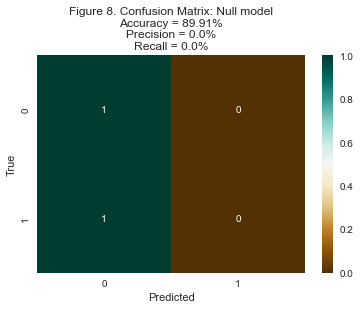

In [19]:
# Predict all non-defaulters
y_pred = np.zeros(len(y_train))
plot_confusion_matrix(y_train, y_pred, title = 'Figure 8. Confusion Matrix: Null model')

#### Initializing PyCaret

To create our Machine Learning (ML) models, we are going to use the [PyCaret](https://pycaret.readthedocs.io/en/latest/index.html) library.  PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows.

**PyCaret setup**

Setup function initializes the training environment and creates the transformation pipeline.

In [20]:
# To use the Pycaret library we need our data to contain the target variable
train_data = X_train.copy()
train_data['target'] = y_train
test_data = X_test.copy()
test_data['target'] = y_test

In [21]:
# Initial setup
models = setup(data=train_data, target='target', session_id=0)                   # session_id is the equivalent of random state

,Description,Value
0,session_id,0
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(13336, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


#### Selecting best models
The compare_models function trains and evaluates the performance of all estimators available in the model library using cross-validation with 10 Folds and selects the best *n* models based on the average metrics of the folds. We are sorting it by Recall grade and asking for the best two models. 

In this case, the models that perform the best are Decision Tree Classifier and K-nearest Neighbors Classifier (KNN). Because the difference between Decision Tree and KNN is quite high, we will select Decision Tree Classifier as model to work. As expected, models are having troubles classifying default loans. Our highest recall score is only 15.79%. 

In [22]:
# Compare model results
best_models = compare_models(sort='Recall', n_select=1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8145,0.5257,0.1632,0.1427,0.1516,0.0484,0.0487,0.0410
xgboost,Extreme Gradient Boosting,0.8912,0.6965,0.0400,0.2773,0.0694,0.0443,0.0695,0.5270
nb,Naive Bayes,0.8860,0.7197,0.0358,0.2121,0.0605,0.0289,0.0446,0.0080
knn,K Neighbors Classifier,0.8886,0.5857,0.0316,0.1960,0.0541,0.0273,0.0404,0.0920
qda,Quadratic Discriminant Analysis,0.8881,0.7190,0.0253,0.1935,0.0440,0.0181,0.0315,0.0230
lightgbm,Light Gradient Boosting Machine,0.8968,0.7201,0.0189,0.3698,0.0359,0.0262,0.0635,0.2360
catboost,CatBoost Classifier,0.8969,0.7221,0.0126,0.3212,0.0242,0.0169,0.0457,2.3250
et,Extra Trees Classifier,0.8972,0.6890,0.0063,0.2667,0.0123,0.0077,0.0268,0.2810
rf,Random Forest Classifier,0.8976,0.6939,0.0042,0.2700,0.0082,0.0053,0.0231,0.3770
gbc,Gradient Boosting Classifier,0.8972,0.7363,0.0032,0.1500,0.0061,0.0028,0.0088,0.4760


#### Understanding best model
The model that we selected is a Decision Tree Classifier with the following parameters:

DecisionTreeClassifier(
    
                       ccp_alpha=0.0,
                       class_weight=None,
                       criterion='gini',
                       max_depth=None, 
                       max_features=None, 
                       max_leaf_nodes=None,
                       min_impurity_decrease=0.0, 
                       min_impurity_split=None,
                       min_samples_leaf=1, 
                       min_samples_split=2,
                       min_weight_fraction_leaf=0.0, 
                       presort='deprecated',
                       random_state=0, 
                       splitter='best'
                       
                       )

In [23]:
# Display the parameters of the best model trained
print('Best model Decision Tree Classifier parameters:\n')
best_models

Best model Decision Tree Classifier parameters:



DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

#### Creating model
The create_model function trains and evaluates the performance of a given estimator using cross validation. In this case we are training the Decision Tree Classifier from above. 

In [24]:
# Creating decision tree classifier
dt_csf = create_model('dt')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8405,0.5472,0.1789,0.1932,0.1858,0.0975,0.0976
1,0.8148,0.5049,0.1158,0.1100,0.1128,0.0095,0.0095
2,0.8041,0.5316,0.1895,0.1452,0.1644,0.0556,0.0562
3,0.8105,0.5211,0.1579,0.1339,0.1449,0.0392,0.0393
4,0.8041,0.5362,0.2000,0.1508,0.1719,0.0633,0.0641
5,0.8199,0.5124,0.1263,0.1237,0.1250,0.0247,0.0247
6,0.7899,0.5144,0.1684,0.1203,0.1404,0.0245,0.0249
7,0.8156,0.5287,0.1684,0.1468,0.1569,0.0539,0.0541
8,0.8264,0.5207,0.1368,0.1398,0.1383,0.0418,0.0418


#### Ensambling model
AdaBoostClassifier(
    
                   algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                         random_state=0,
                                                         splitter='best'),
                   learning_rate=1.0, n_estimators=10, random_state=0)

In [25]:
dt_csf_boost = ensemble_model(dt_csf, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8330,0.5523,0.2000,0.1919,0.1959,0.1027,0.1028
1,0.8244,0.4962,0.0842,0.0941,0.0889,-0.0079,-0.0080
2,0.8105,0.5351,0.1895,0.1525,0.1690,0.0635,0.0639
3,0.8062,0.5048,0.1263,0.1091,0.1171,0.0089,0.0089
4,0.8148,0.5469,0.2105,0.1695,0.1878,0.0846,0.0853
5,0.8178,0.5252,0.1579,0.1429,0.1500,0.0482,0.0483
6,0.7942,0.5121,0.1579,0.1181,0.1351,0.0211,0.0214
7,0.8124,0.5316,0.1789,0.1491,0.1627,0.0580,0.0584
8,0.8264,0.5207,0.1368,0.1398,0.1383,0.0418,0.0418


### Understanding initial Tree branches

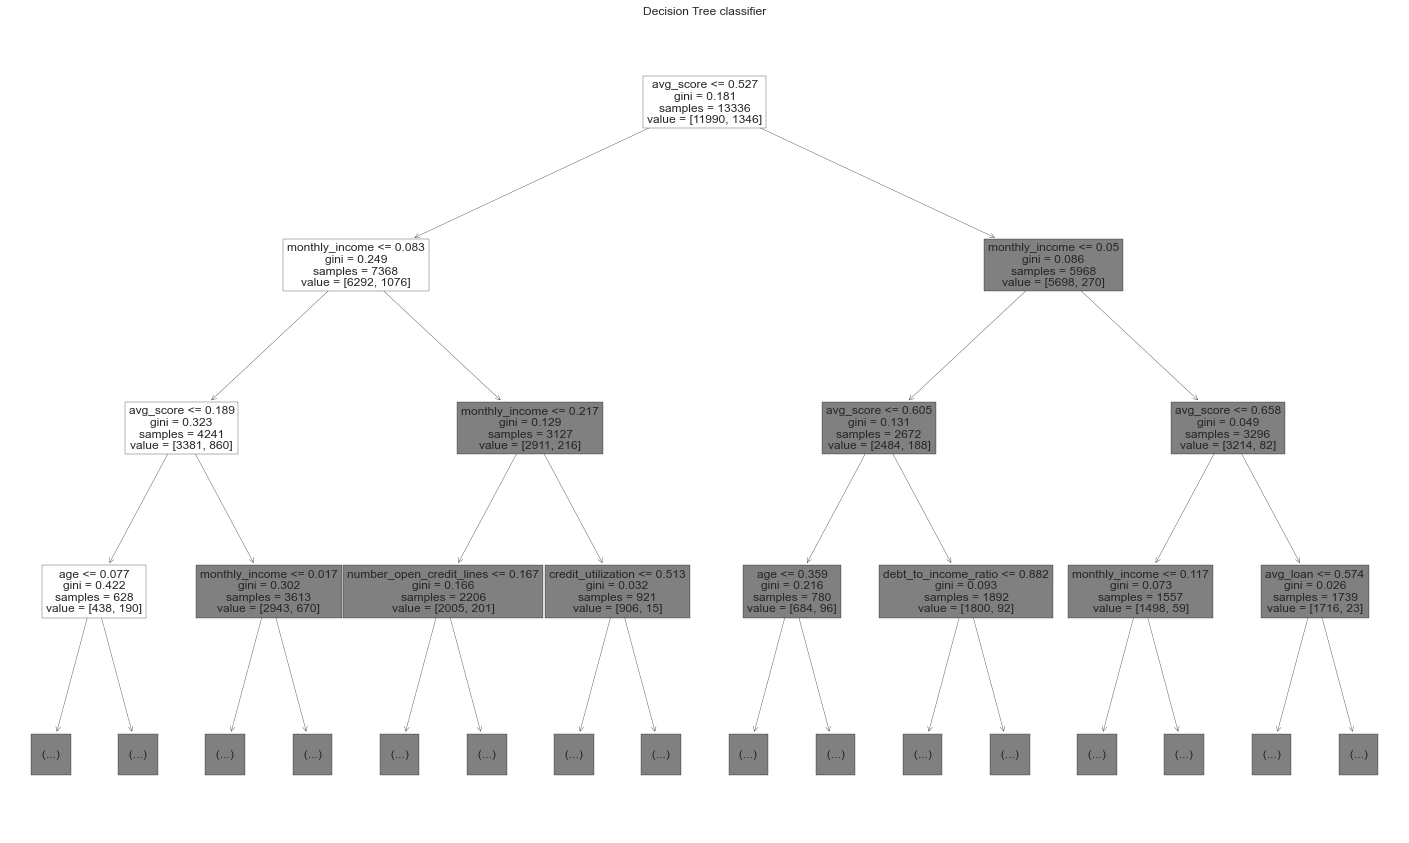

In [26]:
 from sklearn import tree
 # Create tree withour boosting
 tree_model = tree.DecisionTreeClassifier(ccp_alpha=0.0,
                                    class_weight=None,
                                    criterion='gini',
                                    max_depth=None,
                                    max_features=None,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None,
                                    min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    presort='deprecated',
                                    random_state=0,
                                    splitter='best')
# Train model
tree_model.fit(X_train, y_train)

# Plot first 3 branches of tree
plt.figure(figsize=(25,15))
tree.plot_tree(tree_model, max_depth=3, fontsize=12, feature_names=X_train.columns)
plt.title('Decision Tree classifier')
plt.savefig('tree.png')

#### Model dashboard
The dashboard function will generate the interactive dashboard for the model trained.

In [31]:
# Uncomment when running the code for presentation purposes
#dashboard(dt_csf, display_format='dash', run_kwargs={'port' : 70})

Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating shap interaction values... (this may take a while)
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up t

 * Running on http://0.0.0.0:70/ (Press CTRL+C to quit)
10.0.0.212 - - [19/Sep/2022 08:53:42] "GET / HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:42] "GET /assets/bootstrap.min.css?m=1663348647.4006863 HTTP/1.1" 304 -
10.0.0.212 - - [19/Sep/2022 08:53:43] "GET /favicon.ico HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:43] "GET /_dash-dependencies HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:44] "GET /_dash-layout HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:44] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:44] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:44] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:45] "POST /_dash-update-component HTTP/1.1" 204 -
10.0.0.212 - - [19/Sep/2022 08:53:45] "POST /_dash-update-component HTTP/1.1" 200 -
10.0.0.212 - - [19/Sep/2022 08:53:45] "POST /_dash-update-

### 4. Model testing

#### Creating selected model

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Create classifier model
clf = AdaBoostClassifier(algorithm='SAMME.R',
                              base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                         random_state=0,
                                                         splitter='best'),
                   learning_rate=1.0, n_estimators=10, random_state=0)

# Train model
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

#### Applying the model to testing data 

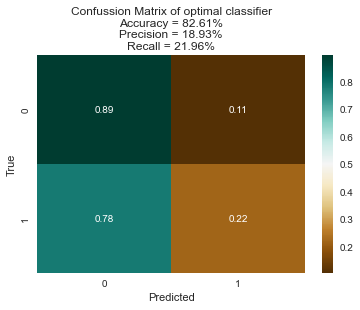

In [29]:
# Apply model to testing data
from stride_functions import *
y_predicted = clf.predict(X_test)

plot_confusion_matrix(y_test, y_predicted, title='Confussion Matrix of optimal classifier')

Text(34.0, 0.5, 'True')

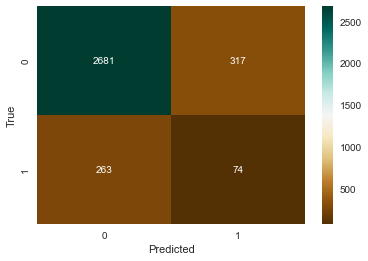

In [30]:
# Genrate confusion matrix
cm = confusion_matrix(y_test, y_predicted)
# Generate heatmap
sns.heatmap(cm, annot=True, cmap='BrBG', fmt='g')
#Ax titles
plt.xlabel('Predicted')
plt.ylabel('True')

### 5. Predicting external testing data

In [32]:
# Apply model to target data 
X_goal = df_test_new.copy()
# Standarize testing dataset
X_goal = standarize(X_goal)
# Apply the model to testing dataset
y_submission = clf.predict(X_goal)
# Convert into a dataframe
y_submission = pd.DataFrame(y_submission)
y_submission.columns = ['Prediction']
# Export to excel
y_submission.to_excel('predictions/predictions.xlsx')